# 분류

## 공통 코드

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from matplotlib import font_manager, rc
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    
mpl.rcParams['axes.unicode_minus'] = False

# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한 
%precision 3
# DataFrame의 출력을 소수점 이하 3자리로 제한 
pd.set_option('precision', 3)

import seaborn as sns

import scipy as sp
from scipy import stats

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

## MNIST

### 데이터 내려받기

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

그림 저장: some_digit_plot


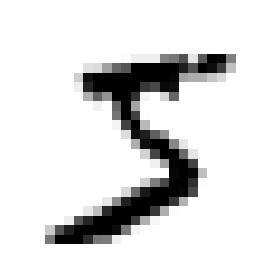

In [5]:
#1개의 이미지 출력
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
#레이블 확인
y[0]

'5'

그림 저장: more_digits_plot


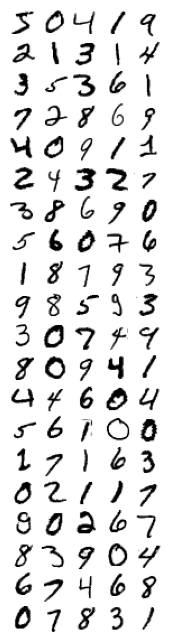

In [7]:
# 숫자 그림을 위한 추가 함수

#여러 개의 이미지 데이터를 행 단위로 출력하는 함수
#instance는 출력할 이미지, images_per_row는 열의 수
def plot_digits(instances, images_per_row=10, **options):
    #이미지 크기 설정
    size = 28
    #열의 개수 설정
    images_per_row = min(len(instances), images_per_row)
    #이미지 전체를 순회하면서 28 * 28로 설정
    images = [instance.reshape(size,size) for instance in instances]
    #행의 개수 구하기
    n_rows = (len(instances) - 1) // images_per_row + 1
    #이미지 들을 저장할 리스트
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    #0으로 가득채운 행렬을 만들어서 images 에 저장
    images.append(np.zeros((size, size * n_empty)))
    #행 단위로 순회하면서 이미지를 추가
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    #이미지 출력
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
    
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=5)
save_fig("more_digits_plot")
plt.show()

## 이진 분류기 생성

In [8]:
#레이블의 값을 정수로 변환
y = y.astype(np.uint8)
#훈련 세트 와 테스트 세트 분류
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
#타겟 벡터 생성
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
#모델 생성 및 학습
from sklearn.linear_model import SGDClassifier

#max_iter는 작업 횟수 이고 tol은 정밀도 random_state는 seed 값
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

#첫번째 데이터를 이용해서 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

# 평가지표

### 정확도 확인

In [11]:
#정확도 확인
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95, 0.96, 0.96])

In [12]:
#5를 분류하는 분류기 - 이진 분류기
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

#분류기 생성
never_5_clf = Never5Classifier()
#새로 만든 분류기의 정확도 확인
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.911, 0.909, 0.909])

### 오차 행렬

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### 평가지표 확인

In [14]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
print("accuracy: %.2f" %accuracy_score(y_train_5, y_train_pred))
print("Precision : %.3f" % precision_score(y_train_5, y_train_pred))
print("Recall : %.3f" % recall_score(y_train_5, y_train_pred))
print("F1 : %.3f" % f1_score(y_train_5, y_train_pred))

accuracy: 0.96
Precision : 0.837
Recall : 0.651
F1 : 0.733


In [15]:
#예측에 사용한 점수
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22])

In [16]:
#임곗값을 0으로 설정
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [17]:
#임곗값을 8000으로 설정
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [18]:
#결정 점수 반환
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
print(y_scores)

[  1200.931 -26883.792 -33072.035 ...  13272.127  -7258.472 -16877.508]


그림 저장: precision_recall_vs_threshold_plot


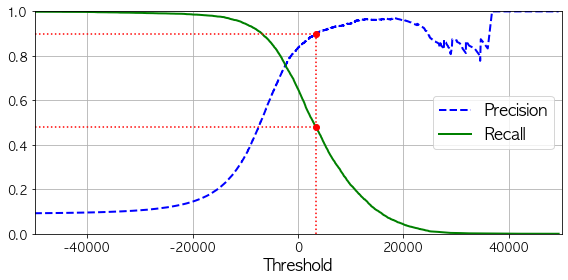

In [19]:
#정밀도 와 재현율 그리고 임계값을 저장
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#정밀도 와 재현율 그리고 임계값을 그래프 그리는 함수
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

#정밀도가 0.9 가 넘는 데이터 중의 인덱스 구하기 - 선을 그리기 위한 값을 찾기
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  

#정밀도와 재현율 출력
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#정밀도와 재현율이 0.9 넘는 자리의 선 그리기
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

그림 저장: precision_vs_recall_plot


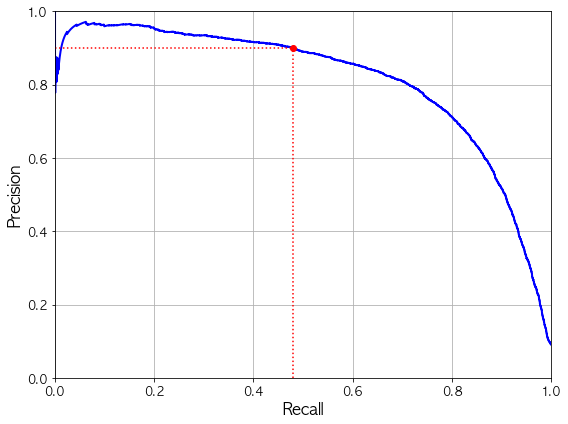

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [21]:
#정밀도가 90%가 되는 지점의 임계값
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439557


In [22]:
#예측을 만들려면 분류기의 predict() 함수를 호출하는 대신 다음 코드를 실행
y_train_pred_90 = (y_scores >= threshold_90_precision)
#정밀도
print(precision_score(y_train_5, y_train_pred_90))
#재현율
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC 곡선

그림 저장: roc_curve_plot


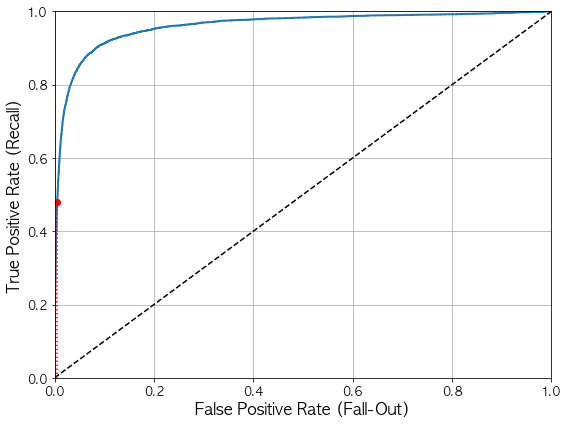

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## 램던 포리스트를 이용한 이진 분류

In [25]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba" )

In [26]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

### SGD 와 RandomForest 의 ROC 곡선 출력

그림 저장: roc_curve_comparison_plot


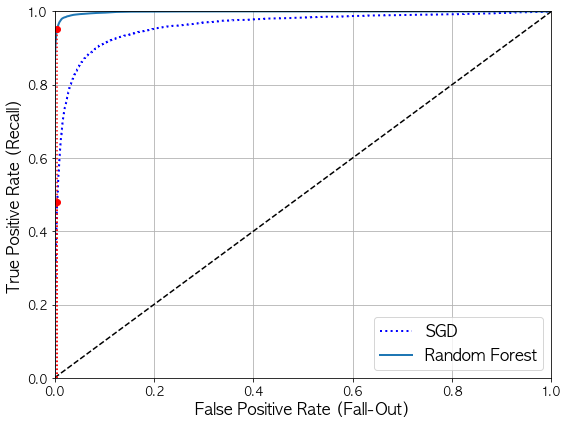

In [27]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [28]:
# ROC AUC 점수
print(roc_auc_score(y_train_5, y_scores_forest))

# 정밀도
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))

# 재현율
print(recall_score(y_train_5, y_train_pred_forest))

0.9983436731328145
0.9905083315756169
0.8662608374838591


## 다중 분류

### sklearn.svm.SVC 클래스를 사용해 서포트 벡터 머신 분류기를 이용한 테스트

In [29]:
#분류기 생성
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
#첫번째 데이터 예측
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [30]:
#결정점수 확인
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.816,  7.092,  3.83 ,  0.794,  5.889,  9.297,  1.799,  8.104,
        -0.228,  4.838]])

In [31]:
#결정 점수가 가장 높은 인덱스 
print(np.argmax(some_digit_scores))

#타겟 리스트
print(svm_clf.classes_)

#인덱스에 해당하는 타겟
svm_clf.classes_[np.argmax(some_digit_scores)]

5
[0 1 2 3 4 5 6 7 8 9]


5

### SVC를 기반으로 OvR 전략을 사용하는 다중 분류기

In [32]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
#분류기로 데이터의 클래스 예측
print(ovr_clf.predict([some_digit]))

#분류기의 클래스 개수
print(len(ovr_clf.estimators_))

[5]
10


In [33]:
#SGD 분류기 이용
sgd_clf.fit(X_train, y_train)
#분류
print(sgd_clf.predict([some_digit]))

#결정 점수 확인
print(sgd_clf.decision_function([some_digit]))

[3]
[[-31893.031 -34419.691  -9530.64    1823.732 -22320.148  -1385.805
  -26188.911 -16147.513  -4604.355 -12050.767]]


In [34]:
#교차 검증을 이용해서 정확도 확인
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.874, 0.858, 0.869])

In [35]:
#데이터를 scailing 한 후 분류
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.898, 0.891, 0.902])

## 에러 분석

### 오차 행렬 출력

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

### 오차 행렬 시각화

그림 저장: confusion_matrix_plot


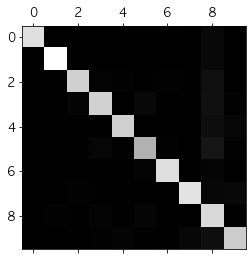

In [37]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()    

그림 저장: confusion_matrix_errors_plot


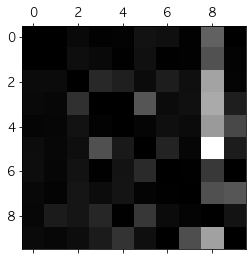

In [38]:
#클래스 별 합계 구하기
row_sums = conf_mx.sum(axis=1, keepdims=True)
#클래스 별 합계로 나누기
norm_conf_mx = conf_mx / row_sums
#주 대각선을 0으로 채움
np.fill_diagonal(norm_conf_mx, 0)
#출력
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

그림 저장: error_analysis_digits_plot


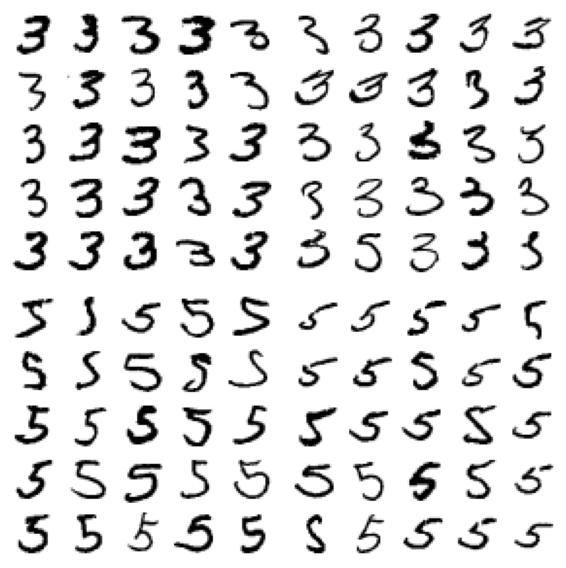

In [39]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

## 다중 레이블 분류

### 분류를 위한 2개의 레이블을 생성

In [40]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

### F1 Score 계산

In [41]:
#오래 걸림
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## 다중 출력 분류

### 잡음이 섞인 이미지 만들기

In [42]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

### 이미지 출력

그림 저장: noisy_digit_example_plot


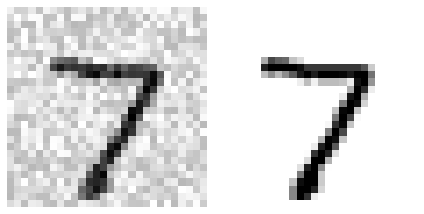

In [43]:
#이미지 1개를 출력하기 위한 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0
plt.subplot(121)
plot_digit(X_test_mod[some_index])
plt.subplot(122)
plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

### 훈련 후 이미지 출력

그림 저장: cleaned_digit_example_plot


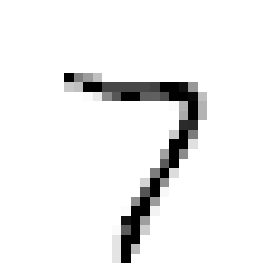

In [44]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

## 판별 분석

### borrower_score 와 payment_inc_ratio에 따른 outcome 선형 판별 분석(LDA)

In [45]:
#데이터 가져오기
loan3000 = pd.read_csv('./data/loan3000.csv')
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

#데이터 읽어오기
X = loan3000[predictors]
y = loan3000[outcome]

print(X.head())
print()
print(y.head())

   borrower_score  payment_inc_ratio
0            0.40              5.111
1            0.40              5.432
2            0.70              9.230
3            0.40              2.335
4            0.45             12.103

0    paid off
1     default
2    paid off
3    paid off
4     default
Name: outcome, dtype: category
Categories (2, object): ['default', 'paid off']


In [46]:
#LDA 훈련
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
#최적의 borrower_score 와 payment_inc_ratio 값 구하기
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                       0
borrower_score     7.176
payment_inc_ratio -0.100


In [47]:
#예측에 대한 확률 출력
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

   default  paid off
0    0.554     0.446
1    0.559     0.441
2    0.273     0.727
3    0.506     0.494
4    0.610     0.390


In [48]:
#그래프 그리기 - 대각선의 왼쪽은 default 반대쪽은 paid off
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio,default
0,32109,paid off,debt_consolidation,21.23,0.40,5.111,0.554
1,16982,default,credit_card,15.49,0.40,5.432,0.559
2,25335,paid off,debt_consolidation,27.30,0.70,9.230,0.273
3,34580,paid off,major_purchase,21.11,0.40,2.335,0.506
4,14424,default,debt_consolidation,16.46,0.45,12.103,0.610


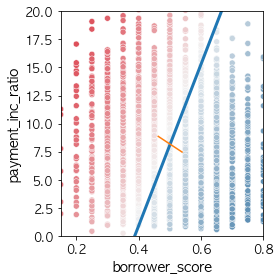

In [49]:
fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

## DummyClassifier

In [50]:
# 라이브러리를 임포트합니다.
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# 데이터를 로드
iris = load_iris()

# 타깃 벡터와 특성 행렬을 생성
features, target = iris.data, iris.target

# 훈련 세트와 테스트 세트로 분리
features_train, features_test, target_train, target_test = train_test_split(
features, target, random_state=0)

# 더미 분류 모델을 생성
dummy = DummyClassifier(strategy='uniform', random_state=1)

# 모델을 훈련
dummy.fit(features_train, target_train)

print(dummy.predict(features_test))
# 정확도 점수를 계산
print(dummy.score(features_test, target_test))

[1 0 0 1 1 0 0 1 0 1 0 2 1 2 0 2 1 2 0 0 2 0 1 2 2 0 1 1 2 0 2 1 1 1 1 2 1
 1]
0.42105263157894735


In [51]:
# 훈련 세트 타깃에서 가장 많은 값으로 예측
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(features_train, target_train)

print(dummy.predict(features_test))
print(dummy.score(features_test, target_test))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]
0.23684210526315788


In [52]:
#MNIST 데이터의 5와 그렇지 않은 이미지의 DummyClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
    
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

dmy_clf = DummyClassifier(strategy='stratified')

# 모델을 훈련합니다.
dummy.fit(X_train, y_train_5)

print(dummy.predict(X_test))
# 정확도 점수를 계산합니다.
print(dummy.score(X_test, y_test_5))

[False False False ... False False False]
0.9108


## KNN

In [53]:
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier
# 모형 객체 생성 (k=5로 설정, metric을 설정하지 않으면 minkowski 거리로 p값이 2이면 유클리드 거리 1이면 맨하턴 거리 기본은 2
knn = KNeighborsClassifier(n_neighbors=5)

In [54]:
from sklearn.neighbors import KNeighborsClassifier

#데이터 불러오기
loan200 = pd.read_csv('./data/loan200.csv')

predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

#테스트 데이터와 예측 변수 및 타겟 벡터 분리
newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

#분류기 생성 - k 의 개수는 20
knn = KNeighborsClassifier(n_neighbors=20)
#훈련 
knn.fit(X, y)
#예측
knn.predict(newloan)


array(['paid off'], dtype=object)

In [55]:
#확률 출력
print(knn.predict_proba(newloan))

[[0.45 0.55]]


### 거리 지표

In [56]:
#가까운 이웃 구하기
nbrs = knn.kneighbors(newloan)
#테스트 데이터와 가장 먼 거리 찾기
maxDistance = np.max(nbrs[0][0])
print(maxDistance)

3.541426301647403


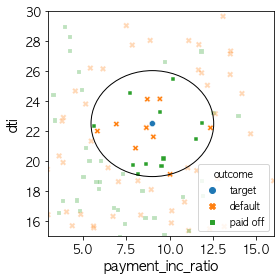

In [57]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

### 표준화

In [58]:
loan_data = pd.read_csv('data/loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)


   payment_inc_ratio  dti  revol_bal  revol_util
0              2.393  1.0       1687         9.4


In [59]:
#정규화를 하지 않은 경우 가까운 5개의 이웃 구하기
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])


       payment_inc_ratio   dti  revol_bal  revol_util
35536              1.472  1.46       1686        10.0
33651              3.382  6.37       1688         8.4
25863              2.363  1.39       1691         3.5
42953              1.282  7.14       1684         3.9
43599              4.122  8.98       1684         7.2


In [60]:
#정규화를 한 경우 5개의 이웃 구하기
from sklearn import preprocessing

newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])


       payment_inc_ratio   dti  revol_bal  revol_util
2080               2.611  1.03       1218         9.7
1438               2.343  0.51        278         9.9
30215              2.712  1.34       1075         8.5
28542              2.398  0.74       2917         7.4
44737              2.343  1.37        488         7.2


### KNN을 통한 피처 엔지니어링

In [61]:
import random
#데이터 읽어오기
loan_data = pd.read_csv('data/loan_data.csv.gz')
#첫번째 행 제거
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
#데이터를 범주형으로 변환
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

#훈련 데이터 와 타겟 벡터 생성
X = loan_data[predictors]
y = loan_data[outcome]

#훈련
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)


KNeighborsClassifier(n_neighbors=20)

count    45342.000
mean         0.501
std          0.129
min          0.000
25%          0.400
50%          0.500
75%          0.600
max          0.950
Name: borrower_score, dtype: float64


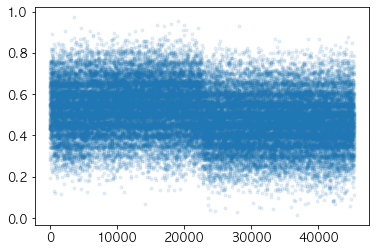

In [62]:
#데이터 시각화
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')

#확률을 구해서 추가
loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
#데이터 출력
print(loan_data['borrower_score'].describe())


### 타이타닉 데이터에 KNN을 적용한 생존자 분류

In [63]:
# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')
#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성 (k=5로 설정, metric을 설정하지 않으면 minkowski 거리로 p값이 2이면 유클리드 거리 1이면 맨하턴 거리 기본은 2
knn = KNeighborsClassifier(n_neighbors=5)

# train data를 가지고 모형 학습
knn.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = knn.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 0 1 0 0 1 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]


In [64]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
knn_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(knn_matrix)

# 모형 성능 평가 - 평가지표 계산
knn_report = metrics.classification_report(y_test, y_hat)            
print(knn_report)


[[111  14]
 [ 24  66]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       125
           1       0.82      0.73      0.78        90

    accuracy                           0.82       215
   macro avg       0.82      0.81      0.82       215
weighted avg       0.82      0.82      0.82       215



### MNIST 에 KNN 적용

In [65]:
from sklearn.metrics import accuracy_score
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
some_digit = X[0]

knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)
y_knn_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_knn_pred)

0.9714

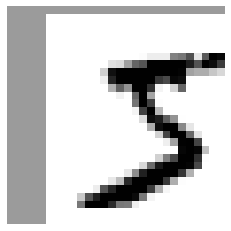

In [66]:
from scipy.ndimage.interpolation import shift
#이미지를 출력하기 위한 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
#이미지를 옮겨주는 함수    
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [67]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [68]:
knn_clf.fit(X_train_expanded, y_train_expanded)
y_knn_expanded_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [69]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.246, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.754]])

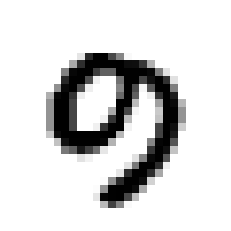

In [70]:
plot_digit(ambiguous_digit)

In [71]:
#몇 시간 걸릴 줄 알지 못함 - 오래 걸림
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  15.2s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  15.0s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  15.1s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  15.3s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  15.0s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  14.7s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  14.9s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  14.9s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  14.9s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  14.9s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  17.0s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [72]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [73]:
grid_search.best_score_

0.9716166666666666

In [74]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 나이브베이즈 분류

### 대출 상환 여부

In [75]:
from sklearn.naive_bayes import MultinomialNB

loan_data = pd.read_csv('./data/loan_data.csv.gz')

#범주형으로 변환
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'

#더미의 가변수 만들기
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

#분류기 생성
#MultinomialNB는 클래스별로 특성의 평균을 계산
#MultinomialNB는 모델의 복잡도를 조절하는 alpha 매개변수 하나를 가지고 있습니다. 
#alpha가 주어지면 알고리즘이 모든 특성에 양의 값을 가진 가상의 데이터 포인트를 alpha 개수만큼 추가합니다. 
#통계 데이터를 완만하게 만들어줍니다. 
#alpha가 크면 더 완만해지고 모델의 복잡도는 낮아집니다.
#alpha에 따른 알고리즘 성능 변동은 비교적 크지 않아서, alpha 값이 성능 향상에 크게 기여하지 않습니다. 
#이 값을 조정하면 어느 정도는 정확도를 높일 수 있습니다.
#fit_prior은 사전 확률을 학습할지 여부 false이면 균일 한 확률

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
#naive_model = MultinomialNB(alpha=0, fit_prior=False)
naive_model.fit(X, y)

MultinomialNB(alpha=0.01)

In [76]:
#146번 데이터 예측
new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

#확률 출력
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)


predicted class:  default
predicted probabilities
   default  paid off
0    0.654     0.346


### 타이타닉

In [77]:
# load_dataset 함수를 사용하여 titanic 데이터 가져오기
df = sns.load_dataset('titanic')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [78]:
#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]


In [79]:
# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [80]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = gnb.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
gnb_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(gnb_matrix)

# 모형 성능 평가 - 평가지표 계산
gnb_report = metrics.classification_report(y_test, y_hat)            
print(gnb_report)


[0 0 1 0 1 0 1 1 1 0]
[0 0 1 0 0 1 1 1 0 0]
[[95 30]
 [22 68]]
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       125
           1       0.69      0.76      0.72        90

    accuracy                           0.76       215
   macro avg       0.75      0.76      0.75       215
weighted avg       0.76      0.76      0.76       215



## Logistic Regression

### 붓꽃의 종류 분류

In [81]:
#데이터 가져오고 속성 확인
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [82]:
#필요한 데이터 가져오고 변환
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(np.int)  # Iris virginica이면 1 아니면 0

/var/folders/98/j21dd2qs46b69mwc94dgyxnr0000gn/T/ipykernel_2330/3808609465.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)  # Iris virginica이면 1 아니면 0


In [83]:
#모델 훈련
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

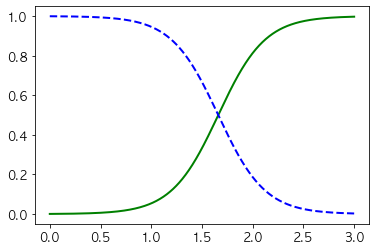

In [84]:
#꽃잎의 너비가 0 부터 3인 데이터를 1000개 생성해서 예측하기
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

/Users/adam/opt/anaconda3/lib/python3.9/site-packages/matplotlib/patches.py:1444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.verts = np.dot(coords, M) + [


그림 저장: logistic_regression_plot


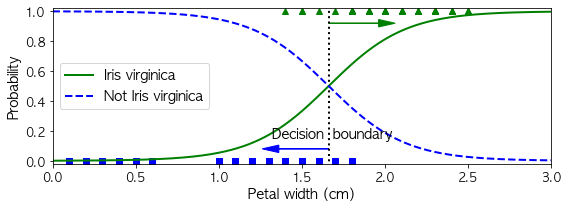

In [85]:
#꽃잎의 너비가 0 부터 3인 데이터를 1000개 생성해서 예측하기
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [86]:
#결정 경계
decision_boundary

array([1.661])

In [87]:
#예측
log_reg.predict([[1.7], [1.5]])

array([1, 0])

/var/folders/98/j21dd2qs46b69mwc94dgyxnr0000gn/T/ipykernel_2330/2385259661.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)


그림 저장: logistic_regression_contour_plot


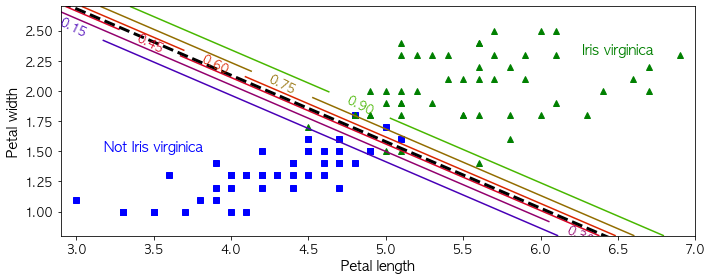

In [89]:
#petal.length 와 petal.width를 이용한 분류
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)

left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

### 다중 분류

그림 저장: softmax_regression_contour_plot


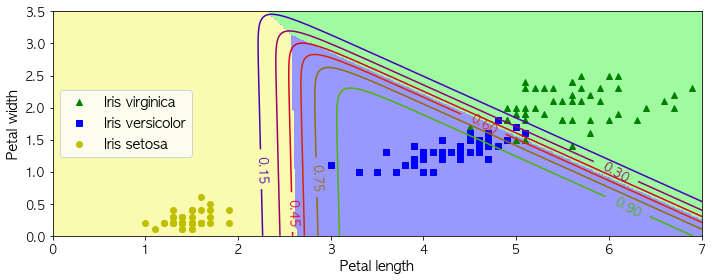

In [90]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

#분류기 훈련
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [91]:
softmax_reg.predict([[5, 2]])

array([2])

In [92]:
softmax_reg.predict_proba([[5, 2]])

array([[6.380e-07, 5.749e-02, 9.425e-01]])

### 타이타닉 생존자 예측

In [93]:
#데이터 가져오기

# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')

#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
#pd.set_option('display.max_columns', 15)
print(df.head())

   survived  pclass     sex   age  sibsp  parch    fare embarked  class  \
0         0       3    male  22.0      1      0   7.250        S  Third   
1         1       1  female  38.0      1      0  71.283        C  First   
2         1       3  female  26.0      0      0   7.925        S  Third   
3         1       1  female  35.0      1      0  53.100        S  First   
4         0       3    male  35.0      0      0   8.050        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


In [94]:
#데이터 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [95]:
#데이터 가공

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  
print(rdf.columns.values)
print('\n')
# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  
print(len(rdf))
print('\n')
# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
print(most_freq)
print('\n')
print(rdf.describe(include='all'))
print('\n')
rdf['embarked'].fillna(most_freq, inplace=True)

['survived' 'pclass' 'sex' 'age' 'sibsp' 'parch' 'fare' 'embarked' 'class'
 'who' 'adult_male' 'alive' 'alone']


714


S


        survived   pclass   sex      age    sibsp    parch     fare embarked  \
count    714.000  714.000   714  714.000  714.000  714.000  714.000      712   
unique       NaN      NaN     2      NaN      NaN      NaN      NaN        3   
top          NaN      NaN  male      NaN      NaN      NaN      NaN        S   
freq         NaN      NaN   453      NaN      NaN      NaN      NaN      554   
mean       0.406    2.237   NaN   29.699    0.513    0.431   34.695      NaN   
std        0.491    0.838   NaN   14.526    0.930    0.853   52.919      NaN   
min        0.000    1.000   NaN    0.420    0.000    0.000    0.000      NaN   
25%        0.000    1.000   NaN   20.125    0.000    0.000    8.050      NaN   
50%        0.000    2.000   NaN   28.000    0.000    0.000   15.742      NaN   
75%        1.000    3.000   NaN   38.000    1.000    1.000   33.375      NaN

In [96]:
# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]
print(ndf.head())   
print('\n')

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)
print(ndf.head())   
print('\n')

   survived  pclass     sex   age  sibsp  parch embarked
0         0       3    male  22.0      1      0        S
1         1       1  female  38.0      1      0        C
2         1       3  female  26.0      0      0        S
3         1       1  female  35.0      1      0        S
4         0       3    male  35.0      0      0        S


   survived  pclass   age  sibsp  parch  female  male  town_C  town_Q  town_S
0         0       3  22.0      1      0       0     1       0       0       1
1         1       1  38.0      1      0       1     0       1       0       0
2         1       3  26.0      0      0       1     0       0       0       1
3         1       1  35.0      1      0       1     0       0       0       1
4         0       3  35.0      0      0       0     1       0       0       1




In [97]:
#데이터 세트 구분 - 훈련용(train data)/ 검증용(test data)
# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (499, 9)
test data 개수:  (215, 9)


In [98]:
#Logistic Regression 분석
from sklearn.linear_model import LogisticRegression

#Logistic Regression 분석 객체를 생성
lr = LogisticRegression(C=1000.0, random_state=1)
#데이터 훈련
lr.fit(X_train, y_train)

print("테스트 모델의 분류 결과")
print(lr.predict_proba(X_test[:5, :]).argmax(axis=1))
print("실제 모델의 분류 결과")
print(y_test[:5])

y_test_pred = lr.predict(X_test)
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
print("accuracy: %.2f" %accuracy_score(y_test, y_test_pred))
print("Precision : %.3f" % precision_score(y_test, y_test_pred, average='micro'))
print("Recall : %.3f" % recall_score(y_test, y_test_pred, average='micro'))
print("F1 : %.3f" % f1_score(y_test, y_test_pred, average='micro'))

테스트 모델의 분류 결과
[0 0 1 0 0]
실제 모델의 분류 결과
728    0
555    0
426    1
278    0
617    0
Name: survived, dtype: int64
accuracy: 0.81
Precision : 0.809
Recall : 0.809
F1 : 0.809


## Support Vector Machine

### Iris-Virginia 품종을 감시하기 위한 선형 SVC Model 훈련

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [101]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

### C 값을 변경한 SVM 분류기

/Users/adam/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


그림 저장: regularization_plot


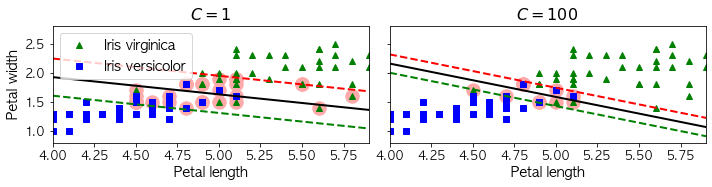

In [104]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "r--", linewidth=2)
    plt.plot(x0, gutter_down, "g--", linewidth=2)

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

### 타이타닉 생존자 예측

In [107]:
# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')
#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (499, 9)
test data 개수:  (215, 9)


In [109]:
from sklearn import svm

# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = svm.SVC(kernel='linear')

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 0 1 0 1 0 1 0 1 0]
[0 0 1 0 0 1 1 1 0 0]


In [110]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

[[106  19]
 [ 28  62]]


              precision    recall  f1-score   support

           0       0.79      0.85      0.82       125
           1       0.77      0.69      0.73        90

    accuracy                           0.78       215
   macro avg       0.78      0.77      0.77       215
weighted avg       0.78      0.78      0.78       215



### 비선형 SVM

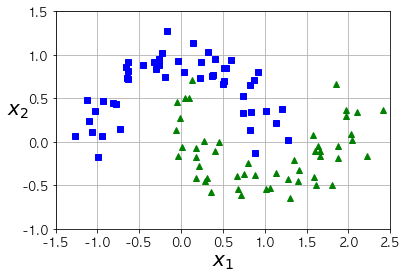

In [111]:
#데이터 생성 및 시각화
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

/Users/adam/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


그림 저장: moons_polynomial_svc_plot


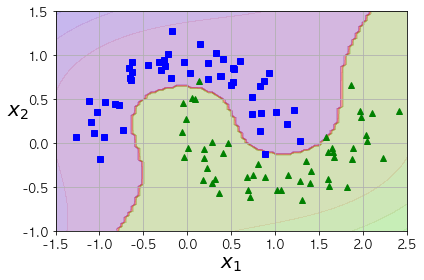

In [112]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()


### 다항식 커널

그림 저장: moons_kernelized_polynomial_svc_plot


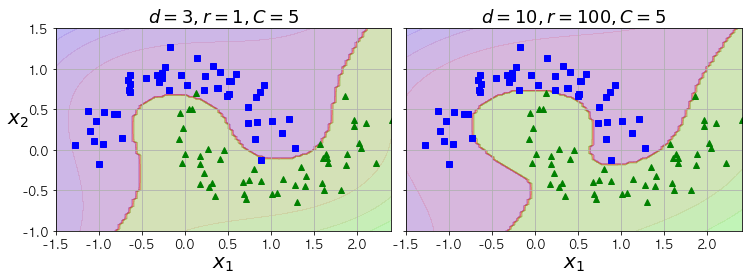

In [113]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

### 가우시안 RBF 커널

In [114]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

그림 저장: moons_rbf_svc_plot


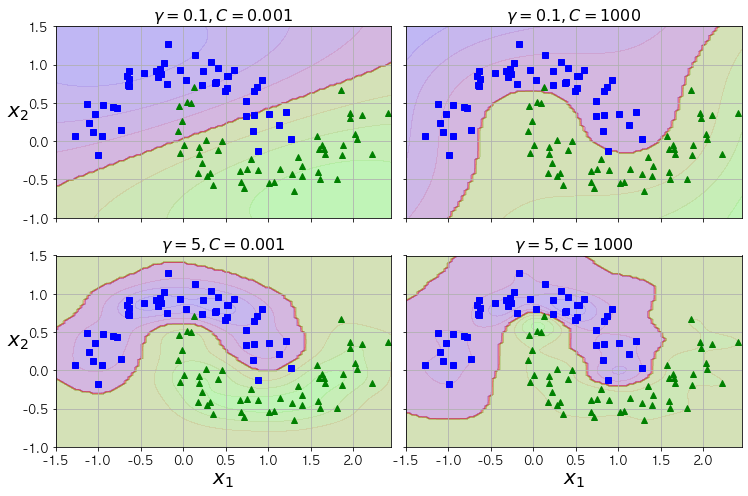

In [115]:
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

### 선형 커널의 문제점

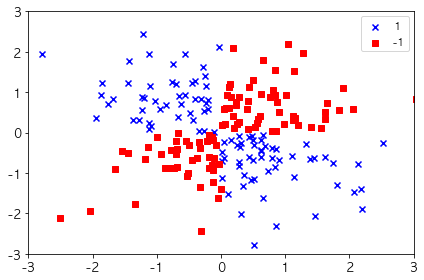

In [116]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [117]:
from matplotlib.colors import ListedColormap

#분류 결과를 그려주는 함수
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 설정합니다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # 테스트 샘플을 부각하여 그립니다.
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')
    
    

/var/folders/98/j21dd2qs46b69mwc94dgyxnr0000gn/T/ipykernel_2330/1804734897.py:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


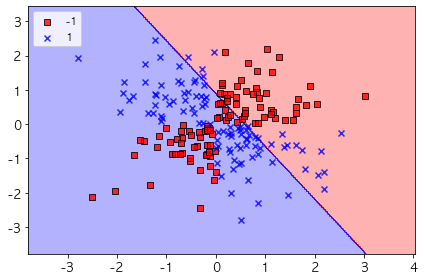

In [118]:
#선형 커널
svm_model = SVC(kernel='linear')
svm_model.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm_model)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/98/j21dd2qs46b69mwc94dgyxnr0000gn/T/ipykernel_2330/1804734897.py:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


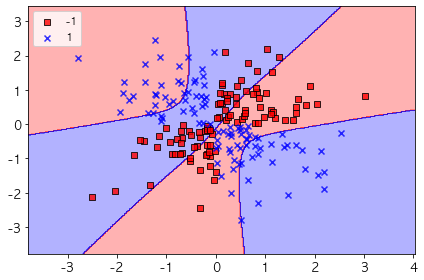

In [119]:
#sigmoid 커널
svm_model = SVC(kernel="sigmoid")
svm_model.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm_model)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/98/j21dd2qs46b69mwc94dgyxnr0000gn/T/ipykernel_2330/1804734897.py:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


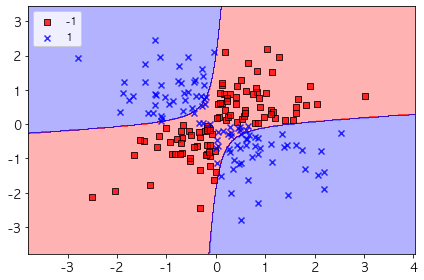

In [120]:
#다차원(2차원) 커널
svm_model = SVC(kernel='poly', degree=2, random_state=1, gamma=0.10, C=10.0)
svm_model.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm_model)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/98/j21dd2qs46b69mwc94dgyxnr0000gn/T/ipykernel_2330/1804734897.py:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


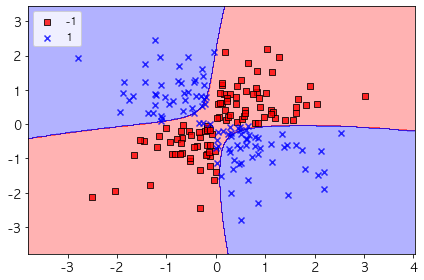

In [121]:
svm_model = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm_model.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm_model)

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 타이타닉 데이터에 sigmoid 커널 적용

In [122]:
# 모형 객체 생성 (kernel='sigmoid' 적용)
svm_model = SVC(kernel='sigmoid')

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 0 1 0 1 0 1 1 1 0]
[0 0 1 0 0 1 1 1 0 0]


In [123]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

[[91 34]
 [24 66]]


              precision    recall  f1-score   support

           0       0.79      0.73      0.76       125
           1       0.66      0.73      0.69        90

    accuracy                           0.73       215
   macro avg       0.73      0.73      0.73       215
weighted avg       0.74      0.73      0.73       215



### 타이타닉 데이터에 2차원 다항 커널 적용

In [124]:
# 모형 객체 생성 (kernel='poly' 적용)
svm_model = SVC(kernel='poly', degree=2, random_state=1, gamma=0.10, C=10.0)

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 0 1 0 1 1 1 0 1 0]
[0 0 1 0 0 1 1 1 0 0]


In [125]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

[[112  13]
 [ 29  61]]


              precision    recall  f1-score   support

           0       0.79      0.90      0.84       125
           1       0.82      0.68      0.74        90

    accuracy                           0.80       215
   macro avg       0.81      0.79      0.79       215
weighted avg       0.81      0.80      0.80       215



### 타이타닉 데이터에 rbf 커널 적용

In [126]:
# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 0 1 0 0 1 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]


In [ ]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)


## Decision Tree

### 모델 생성 및 훈련

In [127]:
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

### 시각화를 위한 패키지 설치

In [128]:
!pip install graphviz
!pip install pygraphviz

     |████████████████████████████████| 46 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 4.1 MB/s eta 0:00:01
  Created wheel for pygraphviz: filename=pygraphviz-1.9-cp39-cp39-macosx_10_9_x86_64.whl size=99385 sha256=19d56536e5316af9a0667444dd27af4ed76b40ba1fbf7be18eba022baf648ca4
  Stored in directory: /Users/adam/Library/Caches/pip/wheels/db/4e/e9/f6d7ead7327fc2dc4e01c57322770a24a36e0f3a10234aa6df
Successfully built pygraphviz


### 모델 시각화

In [145]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

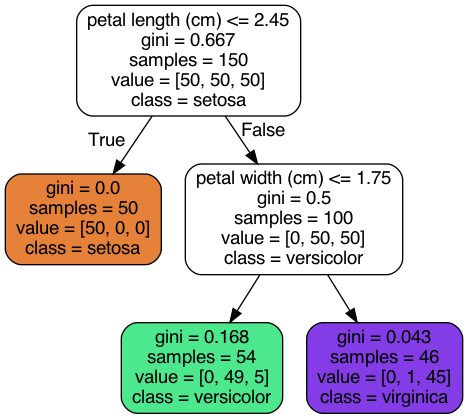

In [146]:
import pygraphviz as pga
from IPython.display import Image

#/Users/adam/Documents/lecture/PYTHON/7.MachineLearning 은 자신의 현재 작업 디렉토리로 변경
graph = pga.AGraph('/Users/adam/Documents/lecture/PYTHON/7.MachineLearning/images/classification/iris_tree.dot')
graph.draw("iris_tree.png", prog='dot')
Image("iris_tree.png")

### 결정 경계

그림 저장: decision_tree_decision_boundaries_plot


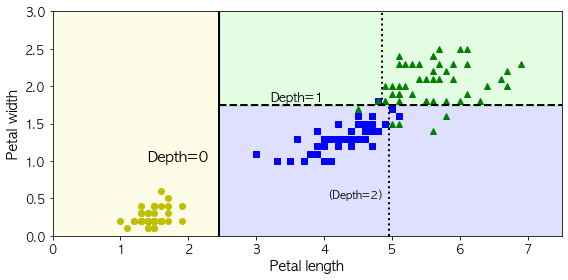

In [147]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()


### 클래스 확률 추정

In [148]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.   , 0.907, 0.093]])

### 클래스 예측

In [149]:
tree_clf.predict([[5, 1.5]])

array([1])

### 규제 매개변수

그림 저장: min_samples_leaf_plot


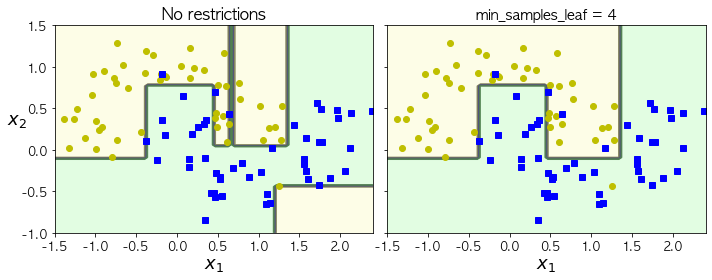

In [150]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

### 타이타닉 생존자 예측

In [152]:
### 기본 라이브러리 불러오기
import pandas as pd
import seaborn as sns

# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')

#  IPython 디스플레이 설정 - 출력할 열의 개수 한도 늘리기
pd.set_option('display.max_columns', 15)

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# sklearn 라이브러리에서 Decision Tree 분류 모형 가져오기
from sklearn import tree
# 모형 객체 생성 (criterion='entropy' 적용 - 기본은 gini)
#최대 가지는 5단계로 설정
#단계가 높아지면 모형 학습에 사용하는 훈련 데이터에 대한 예측은 정확해지만 과적합 문제가 발생할 수 있음
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
# train data를 가지고 모형 학습
tree_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = tree_model.predict(X_test) 

print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
tree_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(tree_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
tree_report = metrics.classification_report(y_test, y_hat)            
print(tree_report)

[0 0 1 0 0 1 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]


[[120   5]
 [ 35  55]]


              precision    recall  f1-score   support

           0       0.77      0.96      0.86       125
           1       0.92      0.61      0.73        90

    accuracy                           0.81       215
   macro avg       0.85      0.79      0.80       215
weighted avg       0.83      0.81      0.81       215



(-1.000, 9.000)

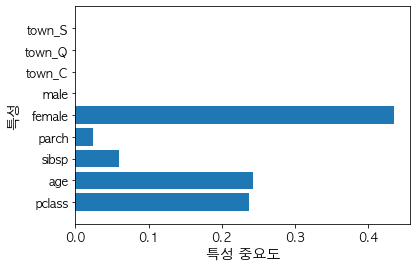

In [153]:
#특성 중요도 파악
n_features = X.data.shape[1]

plt.barh(np.arange(n_features), tree_model.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S'])
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)

### 불안정성

그림 저장: sensitivity_to_rotation_plot


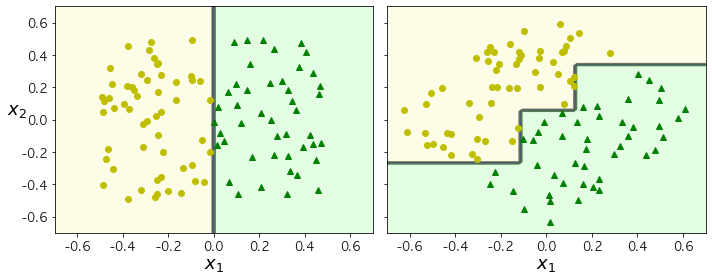

In [154]:
mpl.rcParams['axes.unicode_minus'] = False

np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2
angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)
tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

### 결정 트리 실습- 사용자 행동 인식 데이터 세트

In [156]:
# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./data/UCI HAR Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [157]:
#중복된 피쳐 이름 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [158]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/UCI HAR Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 세트과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/UCI HAR Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/UCI HAR Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/UCI HAR Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/UCI HAR Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [159]:
#데이터 정보 확인
print('## 학습 피처 데이터 세트 info()')
X_train.info()

## 학습 피처 데이터 세트 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [160]:
#행동의 분류 개수 확인
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [161]:
# 반복 시 마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8622
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [162]:
#하이퍼 파라미터 조정
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [ 6, 8 ,10, 12, 16 ,20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치:0.8479
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8}


In [164]:
# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성. 
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트(Evaluation)세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.846
1,8,0.848
2,10,0.840
3,12,0.843
4,16,0.845
5,20,0.845
6,24,0.847


In [165]:
max_depths = [ 6, 8 ,10, 12, 16 ,20, 24]
# max_depth 값을 변화 시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth , accuracy))


max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575
max_depth = 20 정확도: 0.8548
max_depth = 24 정확도: 0.8548


In [166]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8683


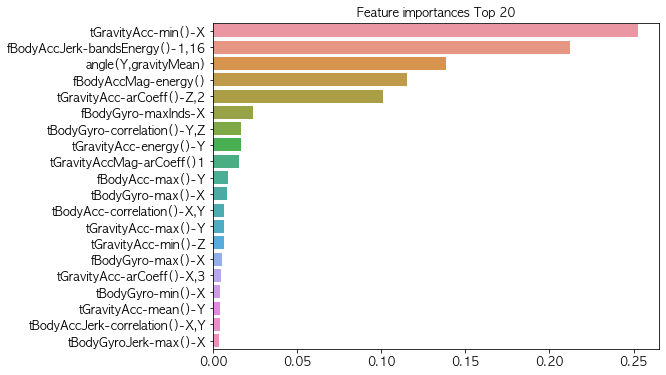

In [167]:
ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()


## 연습 문제

### make_moons(n_samples=1000, noise=0.4)를 사용해 데이터셋을 생성

In [168]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

### train_test_split()을 사용해 훈련 세트와 테스트 세트로 나눔

In [169]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### DecisionTreeClassifier의 최적의 매개변수를 찾기 위해 교차 검증과 함께 그리드 탐색을 수행(GridSearchCV를 사용) 

In [170]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

### 찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정

In [171]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)

In [172]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

### 훈련 세트의 서브셋을 1.000개 생성해서 각각은 무작위로 선택된 1007 개의 샘플을 담도록 작성 

In [173]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

### 이전에 찾은 최적의 매개변수를 사용해 각 서브셋에 결정 트리를 훈련시키고 테스트 세트로 이 1.000개의 결정 트리를 평가

In [174]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

### 테스트 세트 샘플에 대해 1,000개의 결정 트리 예측을 만들고 다수로 나온 예측만 취하기

In [175]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

### 테스트 세트에서 이 예측을 평가 

In [176]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872